In [37]:
import numpy as np 
import pandas as pd

from matplotlib import pyplot as plt 
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture


In [38]:
data = pd.read_csv('/kaggle/input/bank-transaction-dataset-for-fraud-detection/bank_transactions_data_2.csv')

# EDA 

In [39]:
data

,TransactionID,AccountID,TransactionAmount,TransactionDate,TransactionType,Location,DeviceID,IP Address,MerchantID,Channel,CustomerAge,CustomerOccupation,TransactionDuration,LoginAttempts,AccountBalance,PreviousTransactionDate
0,TX000001,AC00128,14.09,2023-04-11 16:29:14,Debit,San Diego,D000380,162.198.218.92,M015,ATM,70,Doctor,81,1,5112.21,2024-11-04 08:08:08
1,TX000002,AC00455,376.24,2023-06-27 16:44:19,Debit,Houston,D000051,13.149.61.4,M052,ATM,68,Doctor,141,1,13758.91,2024-11-04 08:09:35
2,TX000003,AC00019,126.29,2023-07-10 18:16:08,Debit,Mesa,D000235,215.97.143.157,M009,Online,19,Student,56,1,1122.35,2024-11-04 08:07:04
3,TX000004,AC00070,184.50,2023-05-05 16:32:11,Debit,Raleigh,D000187,200.13.225.150,M002,Online,26,Student,25,1,8569.06,2024-11-04 08:09:06
4,TX000005,AC00411,13.45,2023-10-16 17:51:24,Credit,Atlanta,D000308,65.164.3.100,M091,Online,26,Student,198,1,7429.40,2024-11-04 08:06:39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2507,TX002508,AC00297,856.21,2023-04-26 17:09:36,Credit,Colorado Springs,D000625,21.157.41.17,M072,Branch,33,Doctor,109,1,12690.79,2024-11-04 08:11:29
2508,TX002509,AC00322,251.54,2023-03-22 17:36:48,Debit,Tucson,D000410,49.174.157.140,M029,Branch,48,Doctor,177,1,254.75,2024-11-04 08:11:42
2509,TX002510,AC00095,28.63,2023-08-21 17:08:50,Debit,San Diego,D000095,58.1.27.124,M087,Branch,56,Retired,146,1,3382.91,2024-11-04 08:08:39
2510,TX002511,AC00118,185.97,2023-02-24 16:24:46,Debit,Denver,D000634,21.190.11.223,M041,Online,23,Student,19,1,1776.91,2024-11-04 08:12:22


In [40]:
data.isnull().mean()

TransactionID              0.0
AccountID                  0.0
TransactionAmount          0.0
TransactionDate            0.0
TransactionType            0.0
Location                   0.0
DeviceID                   0.0
IP Address                 0.0
MerchantID                 0.0
Channel                    0.0
CustomerAge                0.0
CustomerOccupation         0.0
TransactionDuration        0.0
LoginAttempts              0.0
AccountBalance             0.0
PreviousTransactionDate    0.0
dtype: float64

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2512 entries, 0 to 2511
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   TransactionID            2512 non-null   object 
 1   AccountID                2512 non-null   object 
 2   TransactionAmount        2512 non-null   float64
 3   TransactionDate          2512 non-null   object 
 4   TransactionType          2512 non-null   object 
 5   Location                 2512 non-null   object 
 6   DeviceID                 2512 non-null   object 
 7   IP Address               2512 non-null   object 
 8   MerchantID               2512 non-null   object 
 9   Channel                  2512 non-null   object 
 10  CustomerAge              2512 non-null   int64  
 11  CustomerOccupation       2512 non-null   object 
 12  TransactionDuration      2512 non-null   int64  
 13  LoginAttempts            2512 non-null   int64  
 14  AccountBalance          

### Feature Engineering

In [42]:
data['TransactionDate'] = pd.to_datetime(data['TransactionDate'])
data['PreviousTransactionDate'] = pd.to_datetime(data['PreviousTransactionDate'])

data['TransactionDay'] = data['TransactionDate'].dt.date
data['TransactionHour'] = data['TransactionDate'].dt.hour
data['PreviousTransactionDay'] = data['PreviousTransactionDate'].dt.date
data['PreviousTransactionHour'] = data['PreviousTransactionDate'].dt.hour

data['AgeBinned'] = pd.cut(data['CustomerAge'],bins=[0,25,35,50,60,100], labels=["18 to 25", "25 to 35", "35 to 50",'50 to 60',"60+"])
data['TransactionAccountRatio'] = data['TransactionAmount']/data['AccountBalance']
data['TransactionDurationBinned'] = pd.cut(data['TransactionDuration'], bins=[0, 50, 100, 200, 300],
                                            labels=['Short', 'Medium', 'Long', 'Very Long'])

In [43]:
num_col = data.select_dtypes(['int64','float64']).columns
cat_col = data.select_dtypes(['object','category']).columns

In [44]:
print([(col,data[col].nunique()) for col in cat_col])
print("\n#############################################\n")
print([(col,data[col].nunique()) for col in num_col])


[('TransactionID', 2512), ('AccountID', 495), ('TransactionType', 2), ('Location', 43), ('DeviceID', 681), ('IP Address', 592), ('MerchantID', 100), ('Channel', 3), ('CustomerOccupation', 4), ('TransactionDay', 261), ('PreviousTransactionDay', 1), ('AgeBinned', 5), ('TransactionDurationBinned', 4)]

#############################################

[('TransactionAmount', 2455), ('CustomerAge', 63), ('TransactionDuration', 288), ('LoginAttempts', 5), ('AccountBalance', 2510), ('TransactionAccountRatio', 2512)]


### Proportion plot and visualization

In [46]:
cat_col1 = ['TransactionType','Channel','CustomerOccupation','AgeBinned','LoginAttempts']
cat_col2 = ['Location','DeviceID','MerchantID']


In [47]:
def prop_plot_pie(df, cols):
    sns.set_style("darkgrid")
    cmap = plt.get_cmap("YlOrRd")

    for col in cols:
        counts = df[col].value_counts()
        labels = counts.index
        sizes = counts.values
        
        
        largest_idx = np.argmax(sizes)
        
      
        colors = [cmap(i / len(labels)) for i in range(len(labels))]
        colors[largest_idx] = "gold"  

        plt.figure(figsize=(6, 4))
        plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140,
                colors=colors, wedgeprops={'edgecolor': 'black', 'linewidth': 1})
        plt.title(f"Proportion of {col} in Dataset", fontsize=14)
        plt.show()

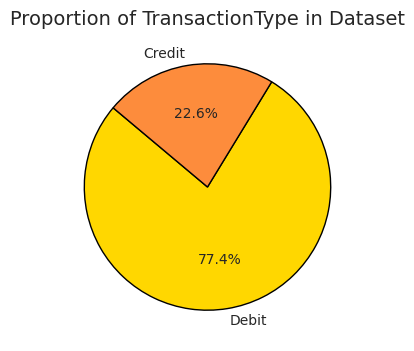

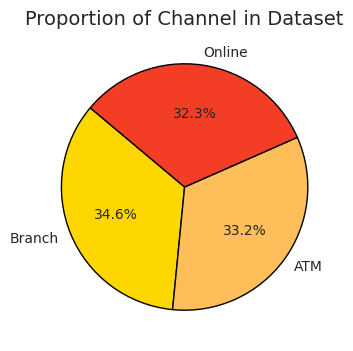

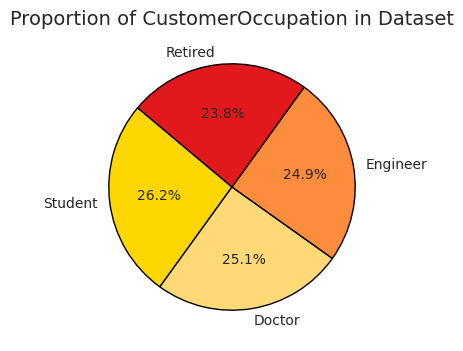

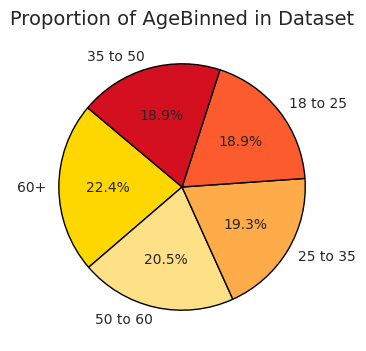

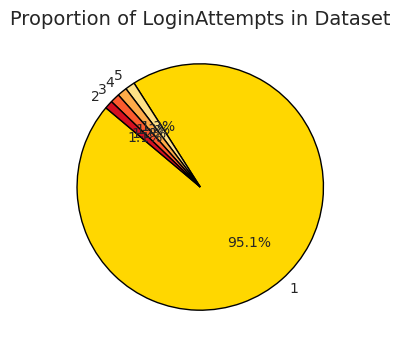

In [48]:
prop_plot_pie(data,cat_col1)

In [49]:
def prop_plot_bar(df, cols, top_n=50, min_count=10):
    sns.set_style("darkgrid")
    cmap = plt.get_cmap("YlOrRd")

    for col in cols:
   
        counts = df[col].value_counts()  
        
        if len(counts) > top_n:
            counts = counts[:top_n]
            counts["Other"] = df[col].value_counts()[top_n:].sum()

        labels = counts.index
        sizes = counts.values

    
        colors = [cmap(i / len(labels)) for i in range(len(labels))]
        largest_idx = np.argmax(sizes)
        colors[largest_idx] = "darkred"  

        plt.figure(figsize=(10, 8))
        bars = plt.barh(labels, sizes, color=colors, edgecolor='black')

   
        for bar, size in zip(bars, sizes):
            plt.text(bar.get_width() + 0.03, bar.get_y() + bar.get_height() / 2,
                     f' {(size / sizes.sum()) * 100:.1f} %', va='center', fontsize=10)

        plt.title(f"Top Categories of {col}", fontsize=14)
        plt.xlabel("Count", fontsize=12)
        plt.ylabel("Category", fontsize=12)
        plt.xscale("log")  
        plt.show()


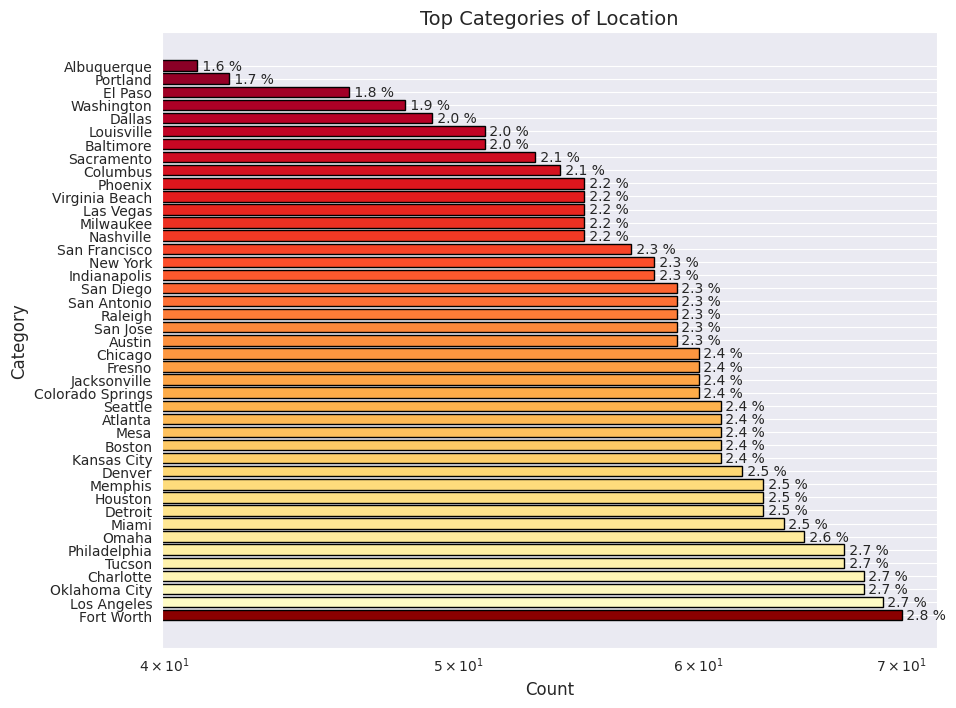

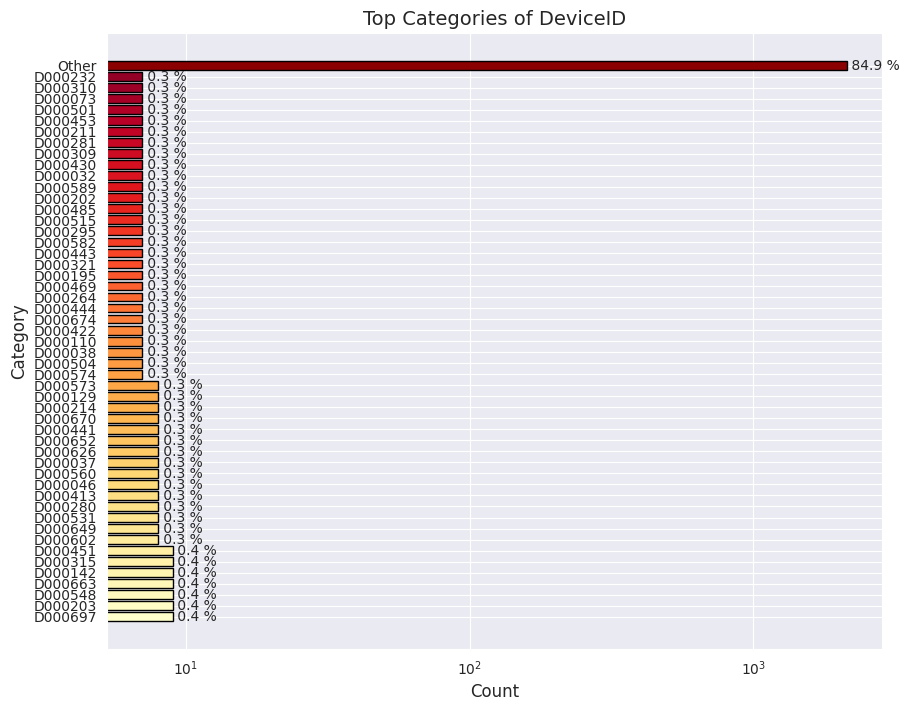

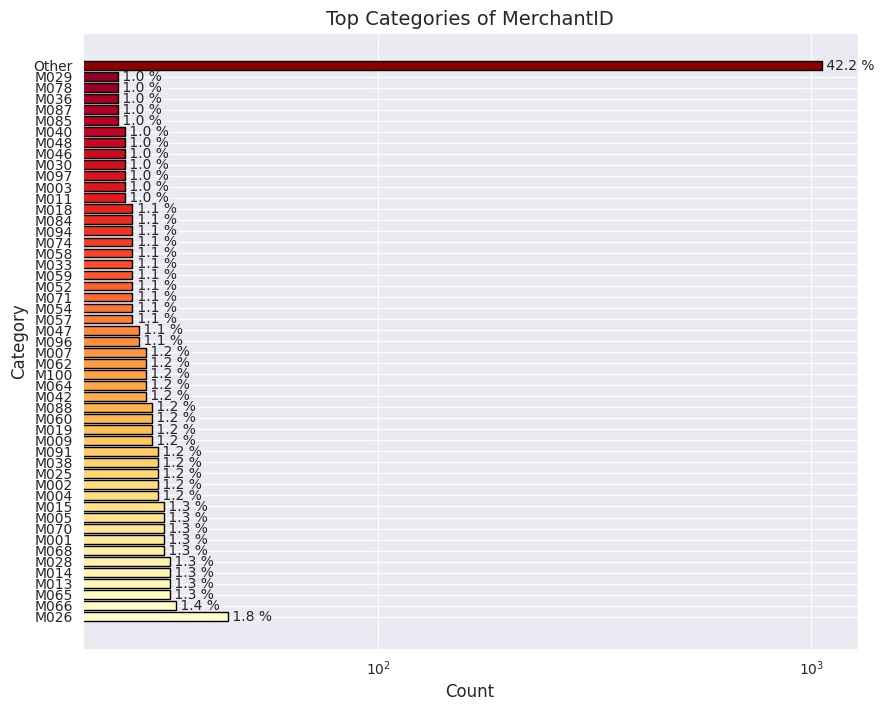

In [50]:
prop_plot_bar(data, cat_col2)

In [51]:
def hist_plot_compare(df0, cols):
    sns.set_style("darkgrid")
    
    cmap = plt.get_cmap("YlOrRd")

    for i, col in enumerate(cols):
        data_0 = df0[col]

        plt.figure(figsize=(6, 4))
        color = cmap(i / len(cols))  
        sns.histplot(data_0, bins=50, color=color, edgecolor='black', alpha=0.7)
        
        plt.title(f"Distribution of {col} in Dataset", fontsize=14)
        plt.xlabel(col, fontsize=12)
        plt.ylabel("Frequency", fontsize=12)
        plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


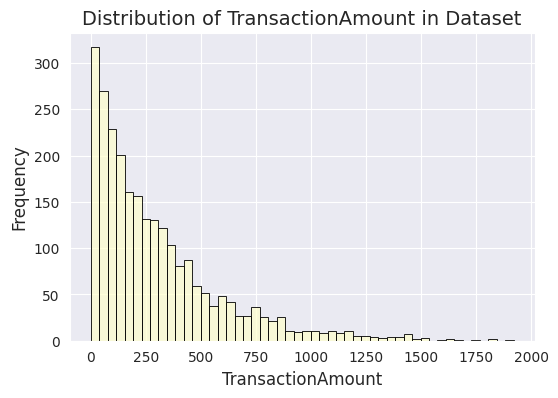

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


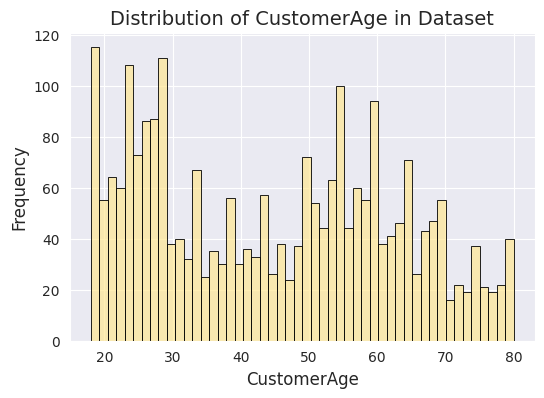

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


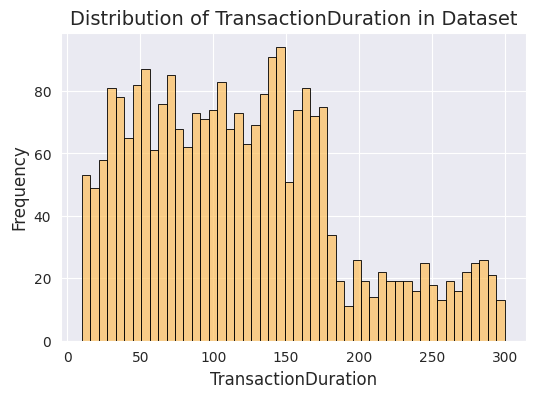

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


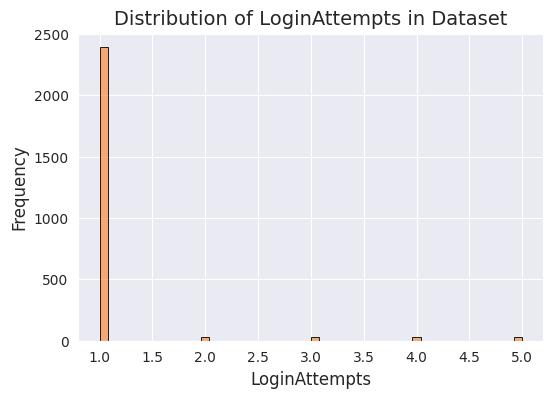

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


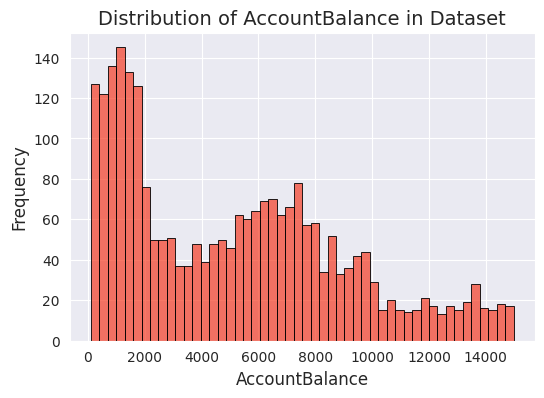

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


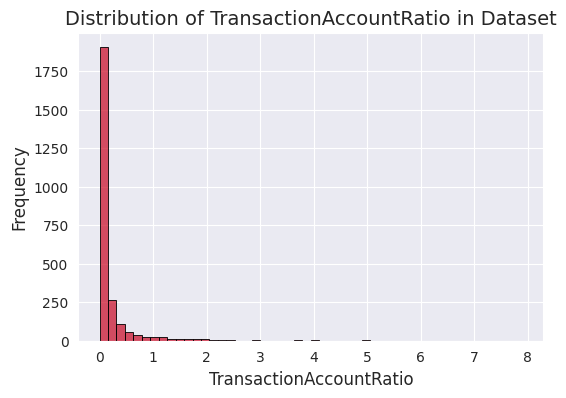

In [52]:
hist_plot_compare(data, num_col)

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


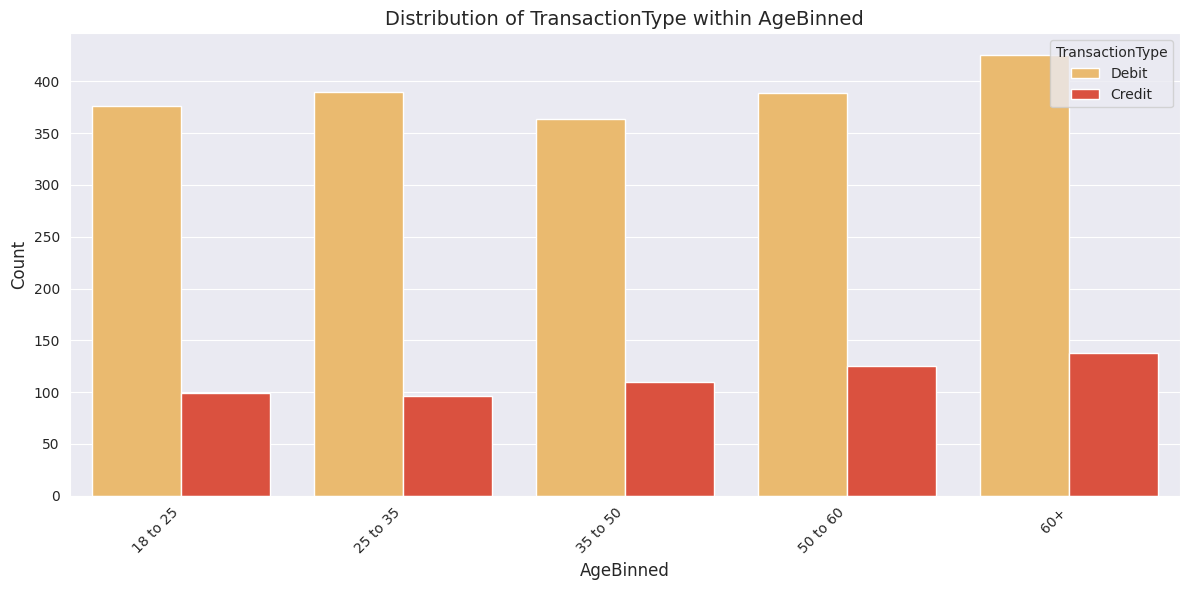

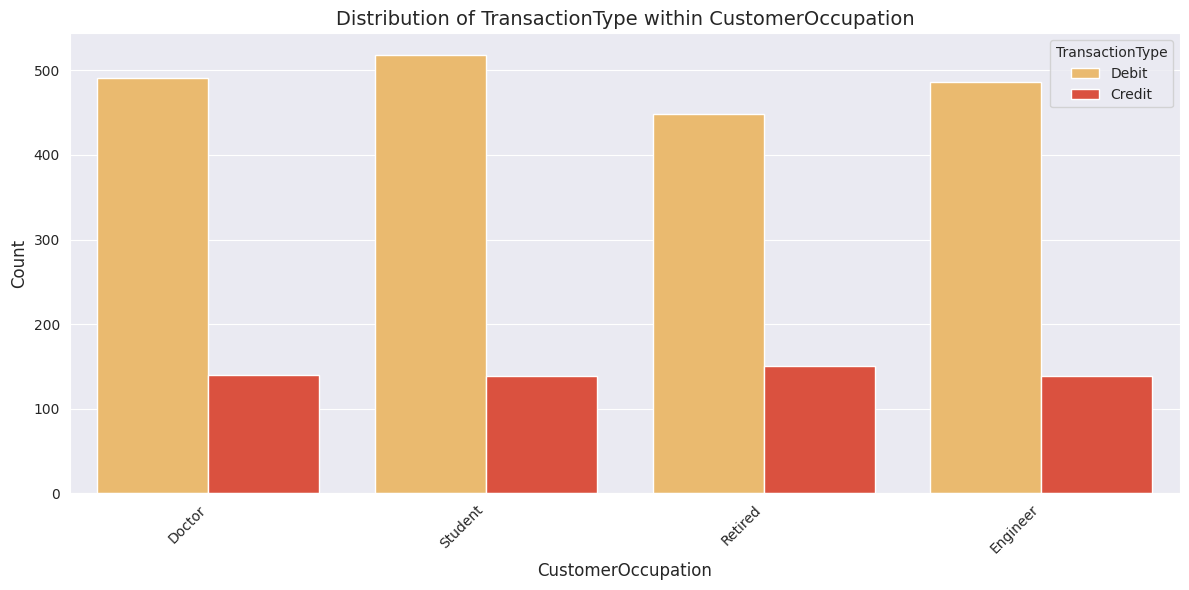

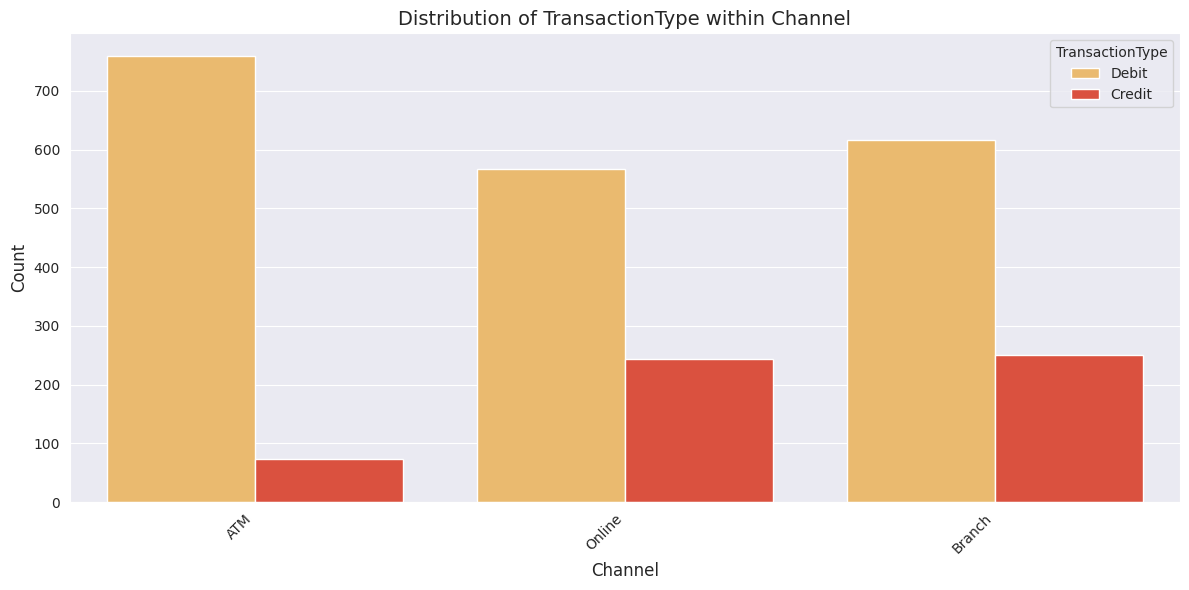

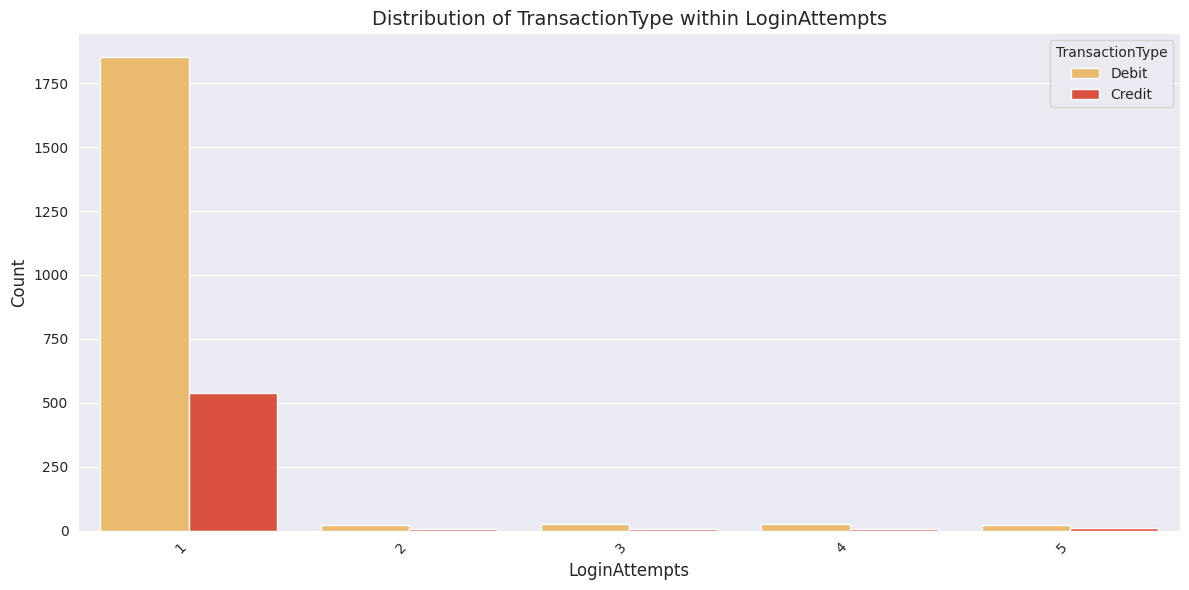

In [53]:
for col in ['AgeBinned', 'CustomerOccupation','Channel','LoginAttempts']:
    plt.figure(figsize=(12, 6))
    
    sns.countplot(x=col, hue='TransactionType', data=data, palette="YlOrRd")
    plt.title(f"Distribution of TransactionType within {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(title='TransactionType', loc="upper right")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

The **EDA** clearly highlights that the fraud detection model will predominantly rely on `LoginAttempts` and ***customer characteristics***. As a result, features like `IP Address`, `Device Type`, or `Machine ID` are unlikely to contribute significantly to our unsupervised approach and may be considered less relevant for model training.

### Outlier Plot 

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


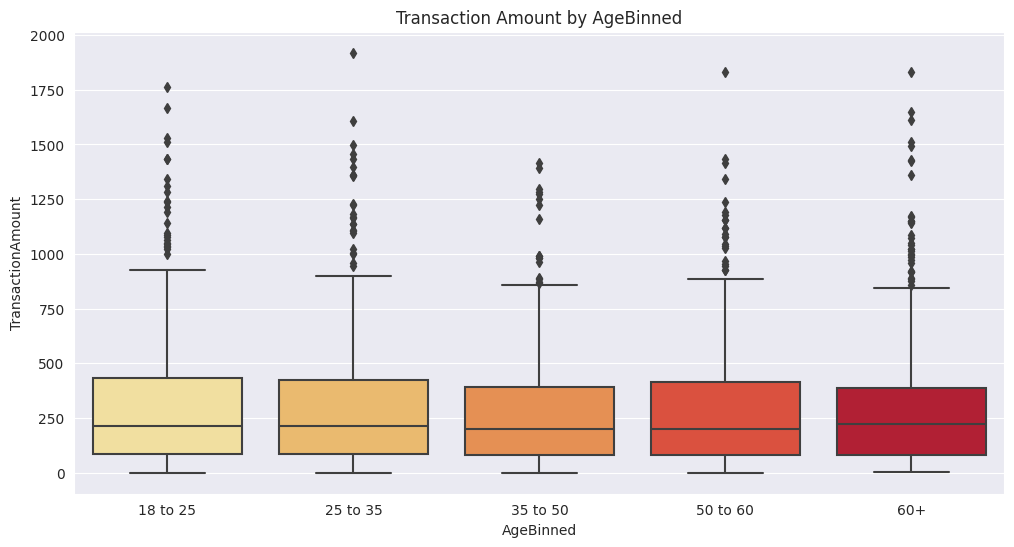

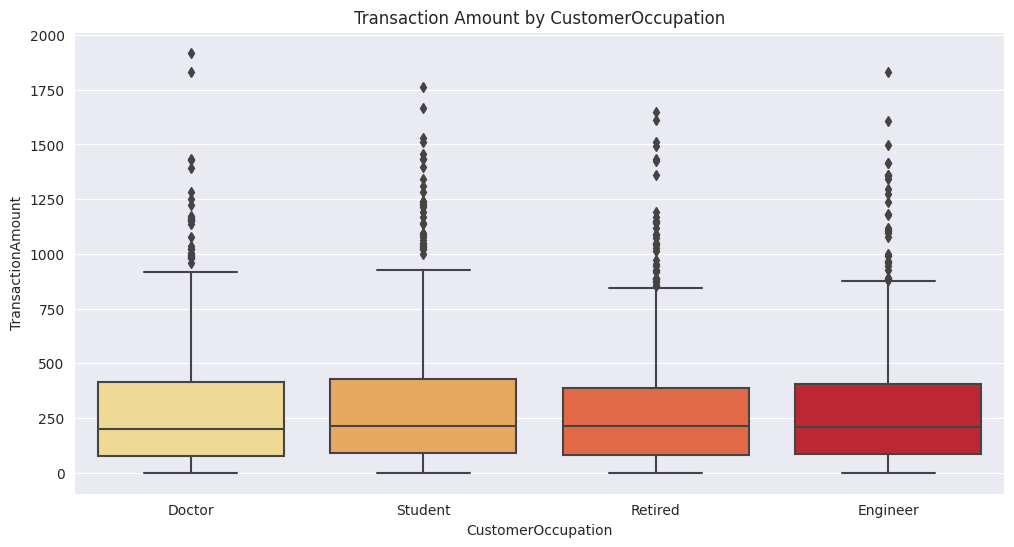

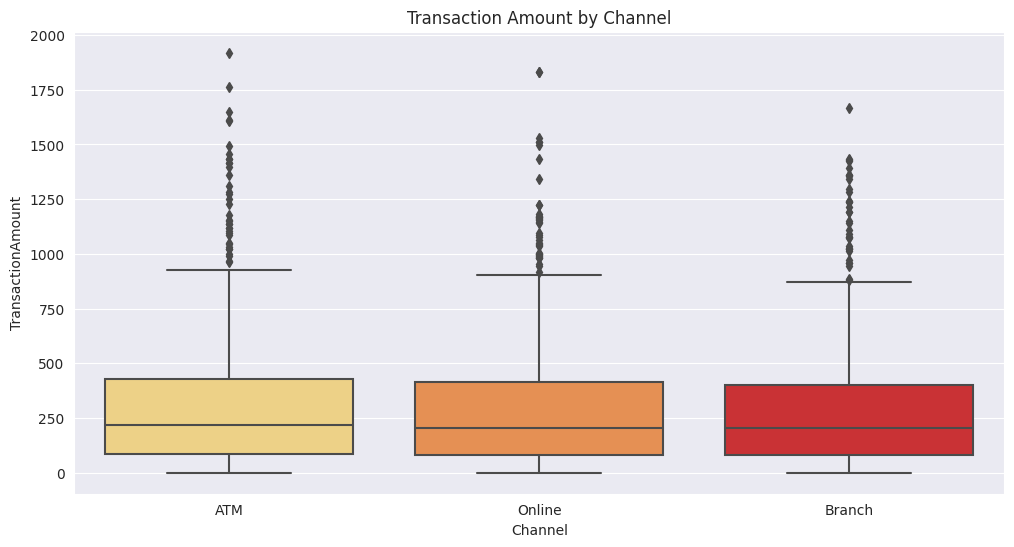

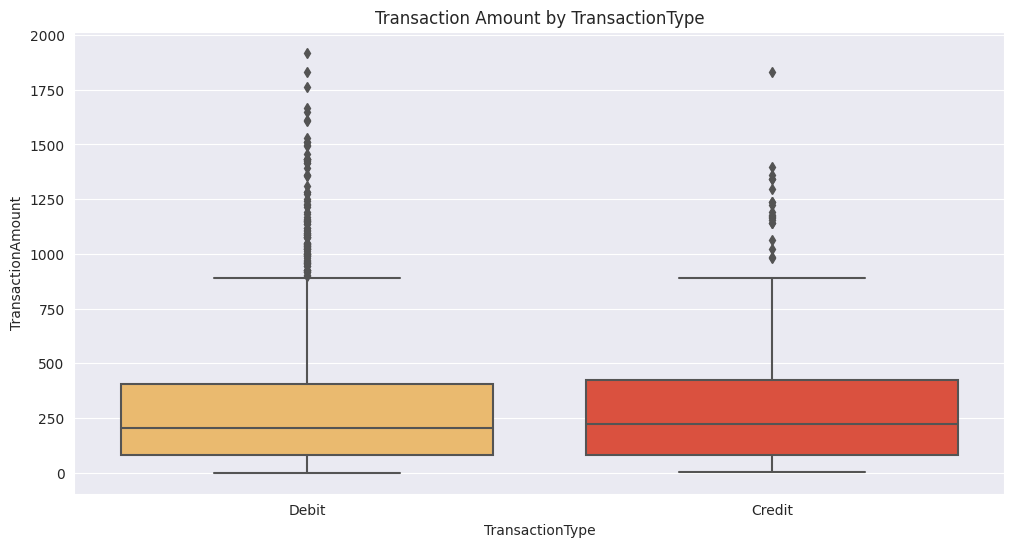

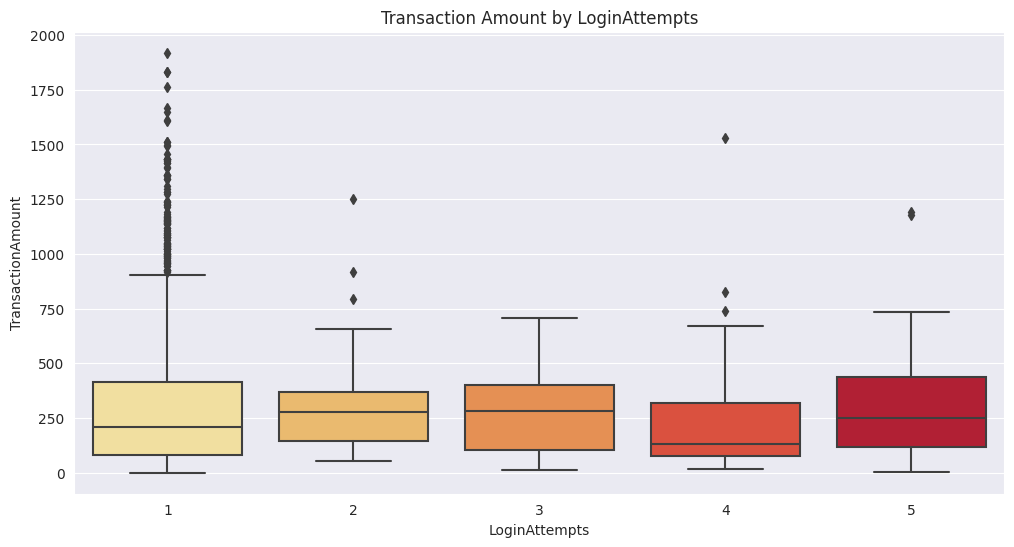

In [54]:
for col in ['AgeBinned', 'CustomerOccupation','Channel','TransactionType','LoginAttempts']:
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=data, x=col, y='TransactionAmount', palette="YlOrRd")
    plt.title(f"Transaction Amount by {col}")
    plt.show()

Typically, **outliers** may be discarded, but for this specific task, outliers could be crucial due to the nature of fraud detection. Therefore, instead of reducing or removing them, we will retain them.

In [68]:
tmp = data.copy()

In [69]:
def create_mapping(column, dataset):
    unique_values = dataset[column].unique()
    return {value: idx for idx, value in enumerate(unique_values)}

cat_col = tmp.select_dtypes(["object","category"]).columns




for col in cat_col:
    mapping = create_mapping(col, tmp)
    tmp[col] = tmp[col].replace(mapping).astype("int64")

/tmp/ipykernel_29/1855614442.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp[col] = tmp[col].replace(mapping).astype("int64")
/tmp/ipykernel_29/1855614442.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tmp[col] = tmp[col].replace(mapping).astype("int64")
/tmp/ipykernel_29/1855614442.py:12: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_

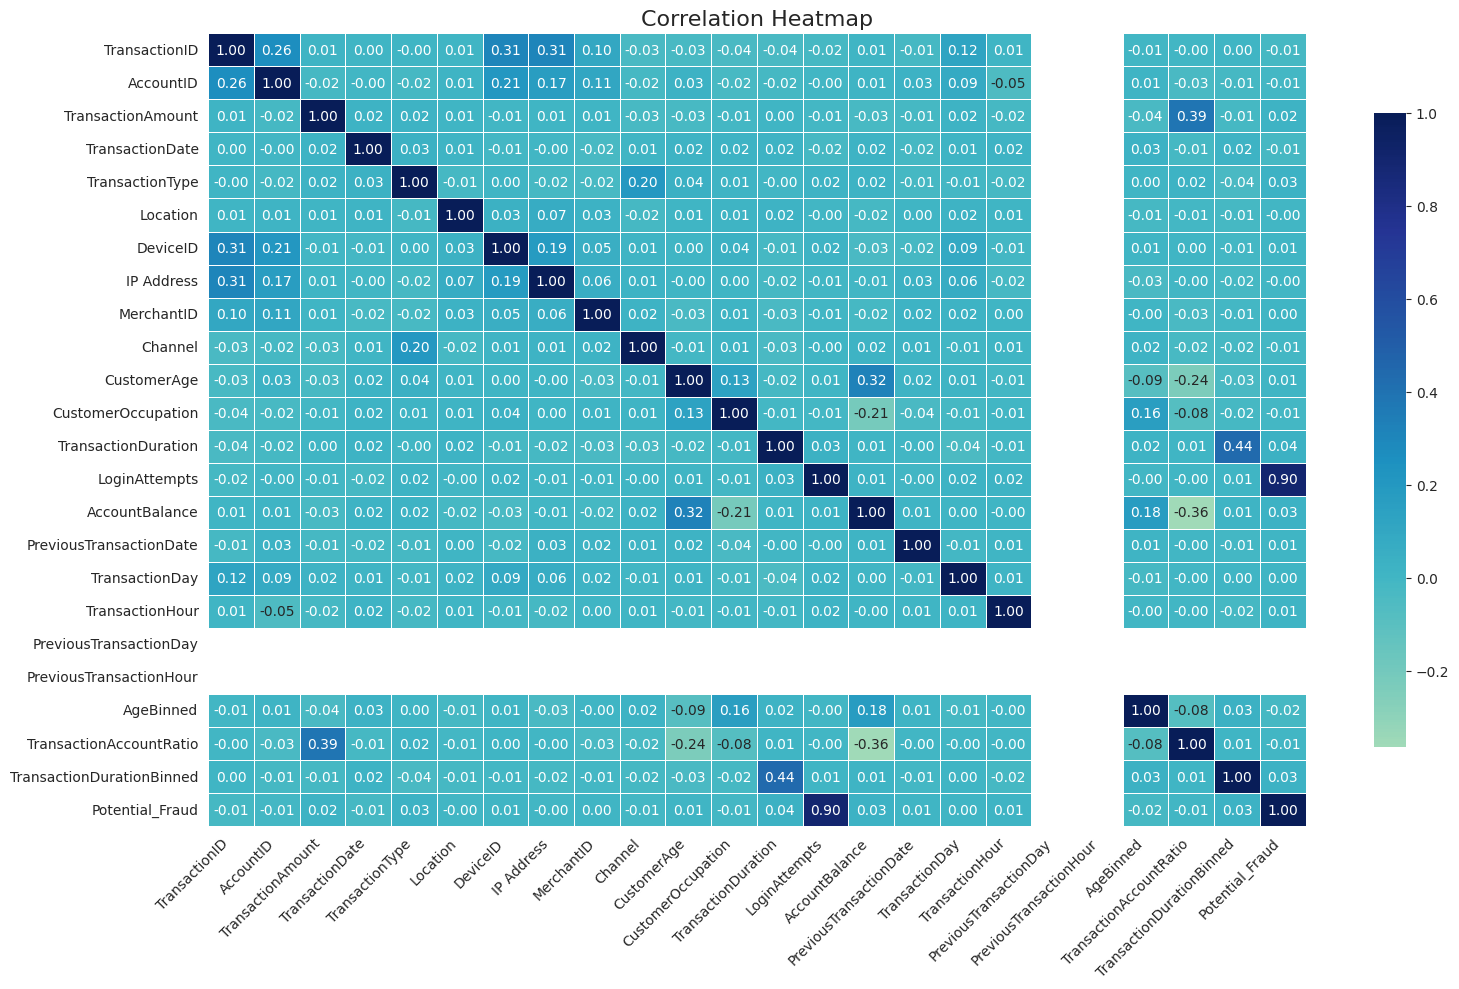

In [70]:
corr_matrix = tmp.corr()

sns.set_style("white")
plt.figure(figsize=(16, 10))

sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu", linewidths=0.5, center=0, fmt=".2f",
            cbar_kws={"shrink": 0.8})

plt.title("Correlation Heatmap", fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


# Clustering Kmeans and GM

In [71]:

X = tmp[['TransactionAmount','TransactionType','TransactionDuration','Channel','LoginAttempts']]


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
#pca = PCA(n_components = 2)
#X_scaled = pca.fit_transform(X)


In [72]:
def Elbow(scaled_data,max_cluster,title,figsize):
    inertia = []
    k_range = range(1, max_cluster +1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(scaled_data)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=figsize)
    plt.plot(k_range, inertia, marker='o')
    plt.title(title)
    plt.xlabel('Number of clusters')
    plt.ylabel('Inertia')
    plt.grid(True)
    plt.show()
    
def Silhouette(scaled_data, max_clusters,title,figsize):

    silhouette_scores = []
    k_range = range(2, max_clusters + 1)

    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(scaled_data)
        silhouette_avg = silhouette_score(scaled_data, cluster_labels)
        silhouette_scores.append(silhouette_avg)

    plt.figure(figsize=figsize)
    plt.plot(k_range, silhouette_scores, marker='o')
    plt.title(title)
    plt.xlabel('Number of clusters')
    plt.ylabel('Silhouette Score')
    plt.xticks(k_range)
    plt.grid(True)
    plt.show()

    return silhouette_scores

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

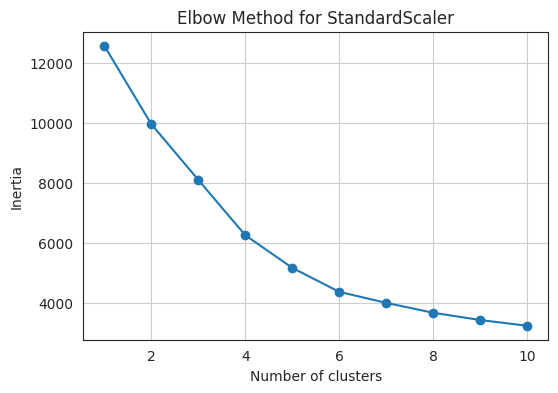

In [73]:
Elbow(X_scaled,10,'Elbow Method for StandardScaler',(6,4))

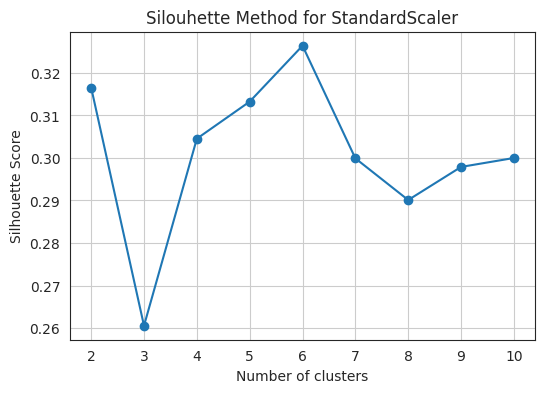

[0.3165511630633591,
 0.2605568639634579,
 0.30453043583505496,
 0.3132450034529365,
 0.32638771207811224,
 0.29990999349648717,
 0.2901126200811062,
 0.2978902432921384,
 0.2999921199803434]

In [74]:
Silhouette(X_scaled,10,'Silouhette Method for StandardScaler',(6,4))

In [75]:
kmeans = KMeans(n_clusters=2, random_state=42)
kmeans_labels = kmeans.fit_predict(X_scaled)

tmp['KMeans_Cluster'] = kmeans_labels


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


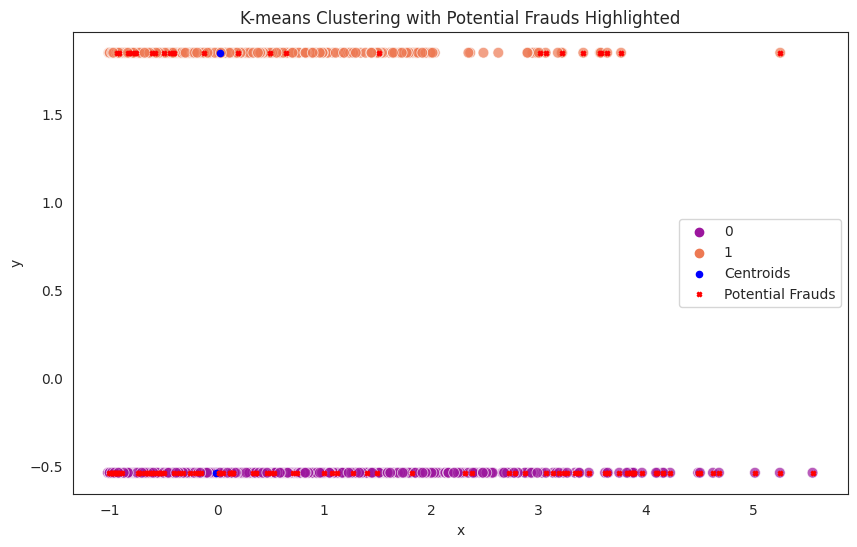

Number of potential frauds detected: 126


In [76]:
distances = np.linalg.norm(X_scaled - kmeans.cluster_centers_[kmeans_labels], axis=1)


threshold = np.percentile(distances, 95) 


tmp['Potential_Fraud'] = distances > threshold


frauds = tmp[tmp['Potential_Fraud']]
non_frauds = tmp[~tmp['Potential_Fraud']]


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=kmeans_labels, palette="plasma", s=60, alpha=0.7)
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], s=20, c='blue', label='Centroids')
plt.scatter(X_scaled[distances > threshold, 0], X_scaled[distances > threshold, 1], 
            color='red', s=10, label='Potential Frauds', marker='X')
plt.title('K-means Clustering with Potential Frauds Highlighted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()


print(f"Number of potential frauds detected: {len(frauds)}")

In [77]:
gmm = GaussianMixture(n_components=2, random_state=42)
gmm.fit(X_scaled)
gmm_labels = gmm.fit_predict(X_scaled)




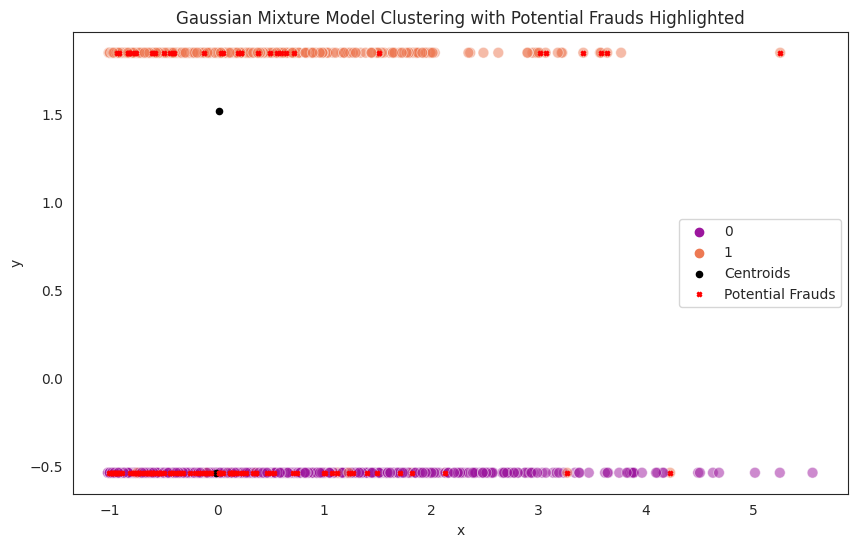

Number of potential frauds detected: 126


In [78]:
mahalanobis_distances = np.sqrt(np.sum(np.dot(X_scaled - gmm.means_[gmm_labels], np.linalg.inv(gmm.covariances_[0])) * (X_scaled - gmm.means_[gmm_labels]), axis=1))


threshold = np.percentile(mahalanobis_distances, 95)


tmp['Potential_Fraud_GMM'] = mahalanobis_distances > threshold
frauds = tmp[tmp['Potential_Fraud_GMM']]
non_frauds = tmp[~tmp['Potential_Fraud_GMM']]


plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_scaled[:, 0], y=X_scaled[:, 1], hue=gmm_labels, palette='plasma', s=60, alpha=0.5)
plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], s=20, c='black', label='Centroids')
plt.scatter(X_scaled[mahalanobis_distances > threshold, 0], X_scaled[mahalanobis_distances > threshold, 1],
            color='red', s=10, label='Potential Frauds', marker='X')
plt.title('Gaussian Mixture Model Clustering with Potential Frauds Highlighted')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()
print(f"Number of potential frauds detected: {len(frauds)}")

In [79]:
data['Potential_Fraud'] = tmp['Potential_Fraud_GMM'].astype(int)

### Fraud Visualization 

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


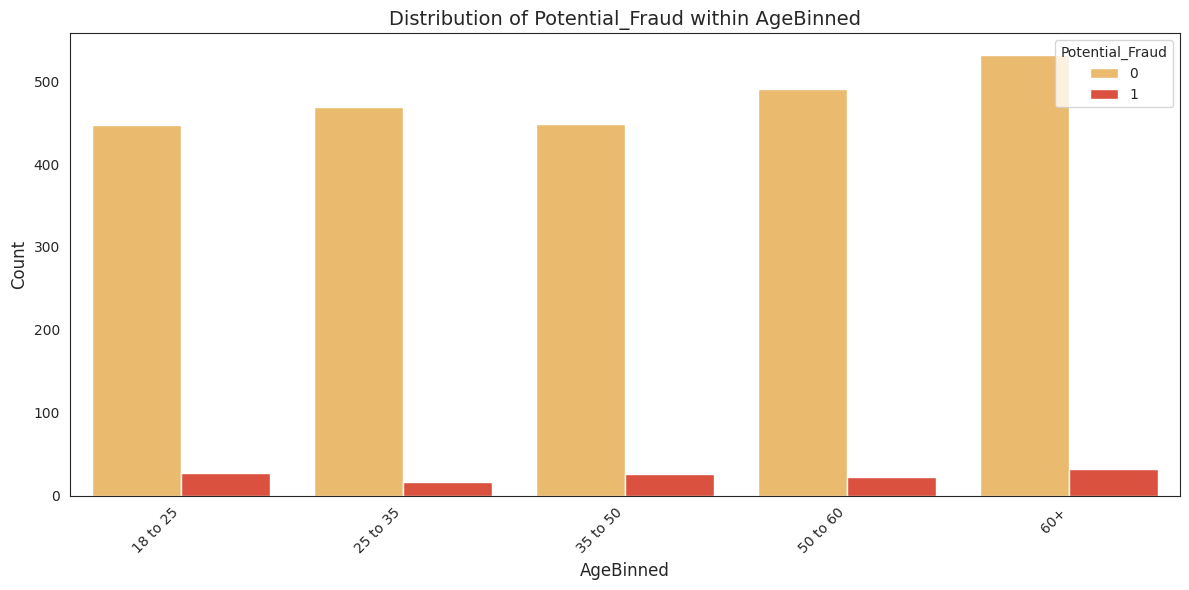

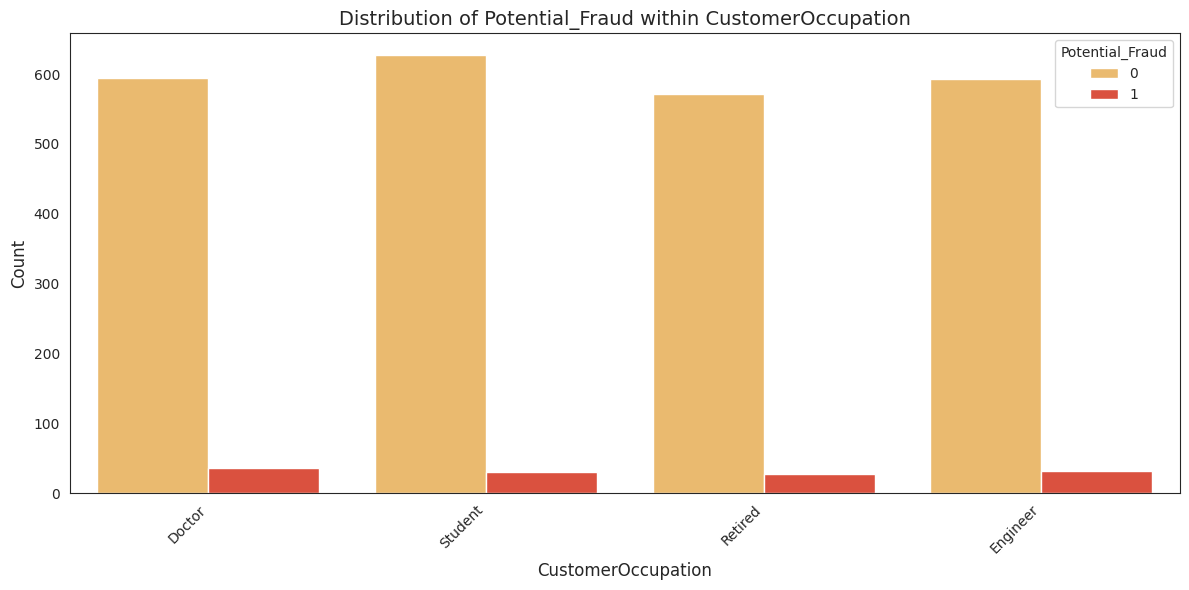

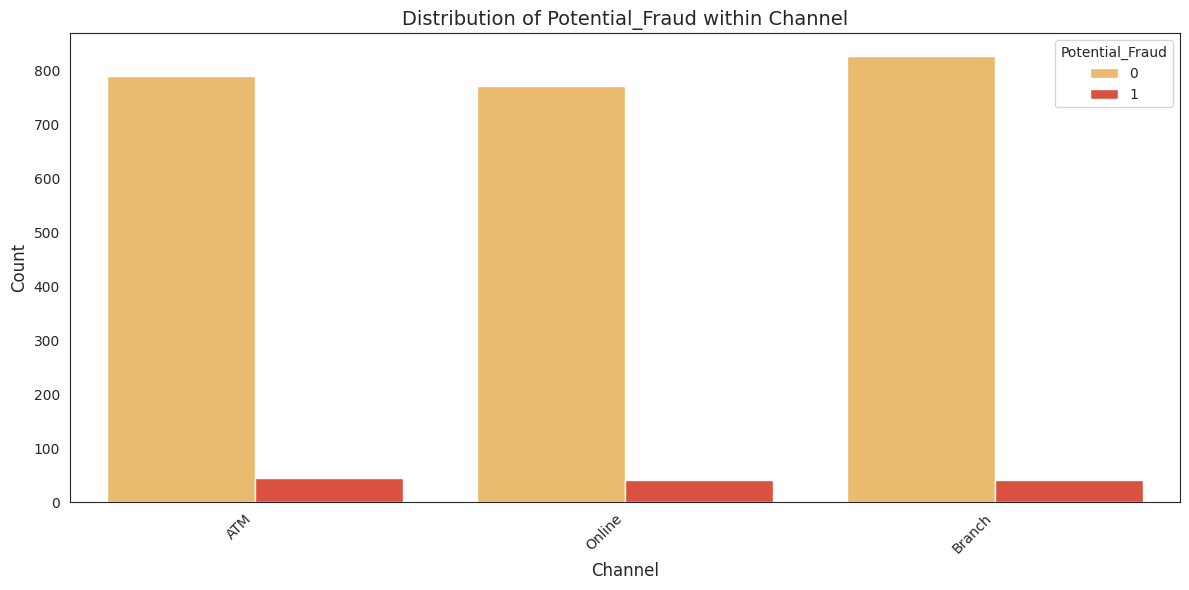

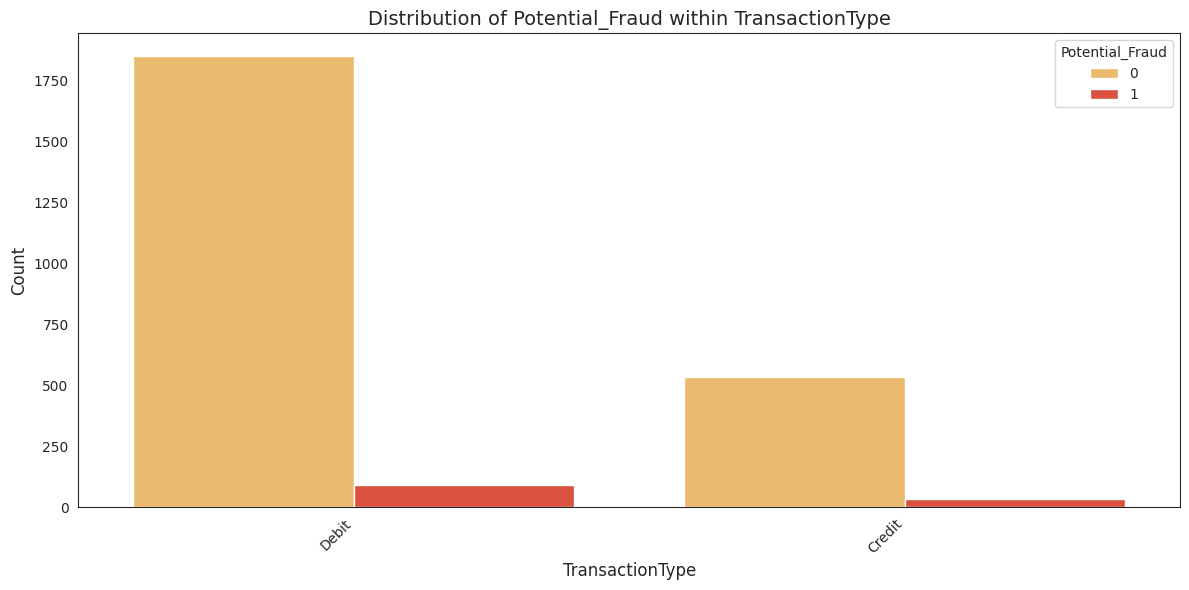

/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/conda/lib/python3.10/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


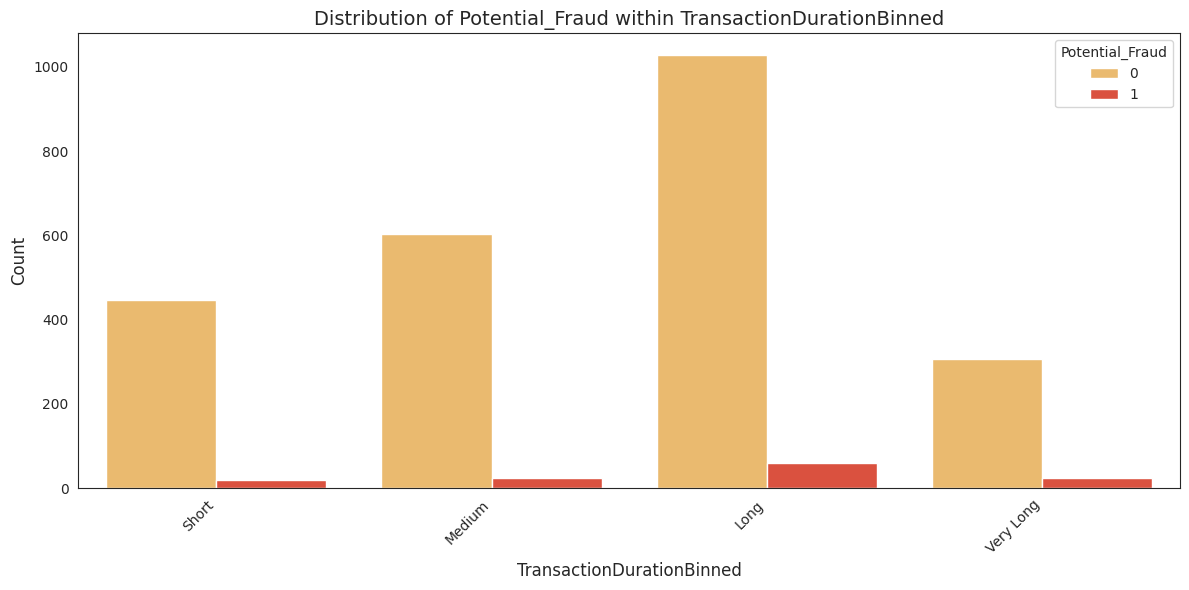

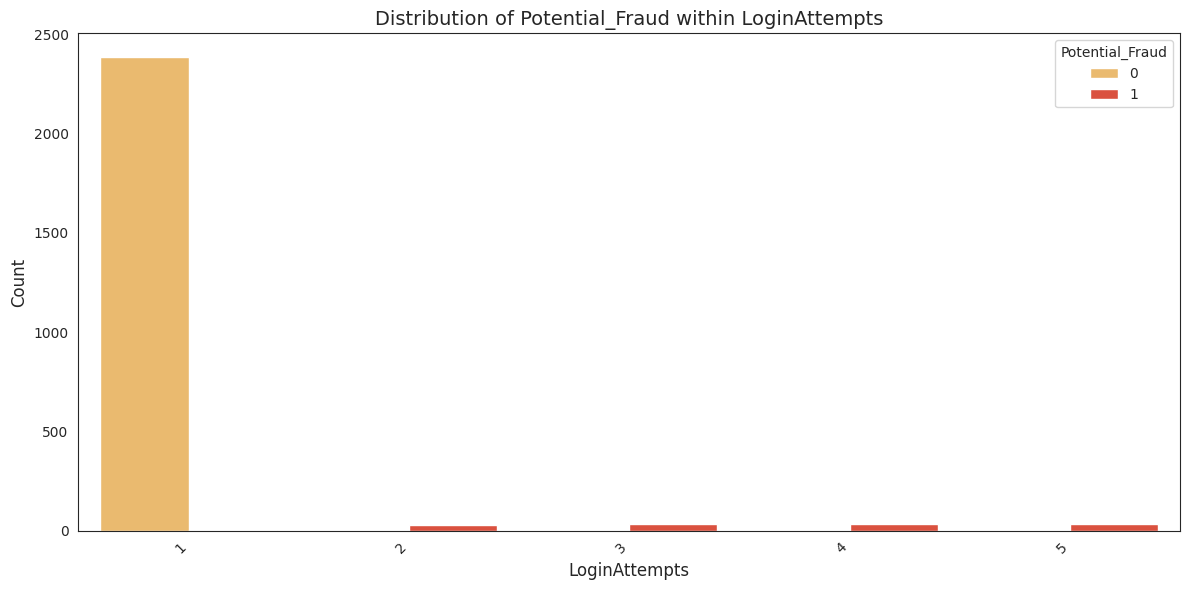

In [80]:
for col in ['AgeBinned', 'CustomerOccupation','Channel','TransactionType','TransactionDurationBinned','LoginAttempts']:
    plt.figure(figsize=(12, 6))
    
    sns.countplot(x=col, hue='Potential_Fraud', data=data, palette="YlOrRd")
    plt.title(f"Distribution of Potential_Fraud within {col}", fontsize=14)
    plt.xlabel(col, fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.legend(title='Potential_Fraud', loc="upper right")
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

Based on the chart results, it is clear that `LoginAttempts` significantly contributed to the performance of the **fraud detection Gaussian Mixture Model**. We can therefore decide to establish a ***threshold*** using metrics like the number of attempted connections and connection duration to make the decision.